In [19]:
from __future__ import annotations

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.typings import LayerSpec


import gdsfactory as gf
import time  # for timestamp-based unique naming
from functools import partial

@gf.cell
def nanowire_cell(
    nw_length=0.1,
    nw_thick=0.0001,
    bridge_thickness=1,
    bridge_length=3
):
    # Create the nanowire cell
    cell = gf.Component('NANOWIRE_CELL')

    # Define nanowire segments
    nw_s_l = 0.5  # Single Nanowire length
    nw_count = int(nw_length / nw_s_l)
    nw_residual = nw_length % nw_s_l

    #NanoWire position
    center_nws = (0, 0)
    
    for i in range(nw_count):
        # Create polygon for the nanowire segment
        wire_thickness = nw_thick
        wire_corners_left = [
            (center_nws[0] + nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] - bridge_thickness / 2 - 0.3, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] - bridge_thickness / 2 - 0.3, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1)),
            (center_nws[0] + nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1))
        ]
        cell.add_polygon(wire_corners_left, layer=(5, 0))

        # Create polygon for the right side nanowire segment
        wire_corners_right = [
            (center_nws[0] - nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1)),
            (center_nws[0] - nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1))
        ]
        cell.add_polygon(wire_corners_right, layer=(5, 0))

        # Handle residual nanowire segment
        if nw_residual > 0.01:
            residual_corners = [
                (center_nws[0] + nw_s_l / 2 - nw_residual, center_nws[1] - nw_thick / 2),
                (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2),
                (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick),
                (center_nws[0] + nw_s_l / 2 - nw_residual, center_nws[1] - nw_thick / 2 + nw_thick)
            ]
            cell.add_polygon(residual_corners, layer=(5, 0))

    return cell






# Example 1: Basic nanowire with default parameters
nanowire1 = nanowire_cell(
    nw_length=11,  # nanowire length
    nw_thick=0.0001,  # nanowire thickness
    bridge_thickness=1,  # thickness of the bridge
    bridge_length=1  # length of the bridge
)



"""# Plot the nanowire cell
nanowire1.plot()
nanowire1.show()"""







@gf.cell
def generate_device_cell(
    bridge_thickness=1,
    bridge_length=3,
    pad_dim_x=250,
    pad_dim_y=250,
    gap=40,
    nw_length=2.1,
    nw_thick=0.1,
    bridge_x_offset=0,  # New parameter for controlling bridge position
    bridge_y_offset=0,  # New parameter for controlling bridge position
    nanowire_x_offset=0,  # New parameter for controlling nanowire position
    nanowire_y_offset=0   # New parameter for controlling nanowire position
):
    # Create the cell with a unique name
    unique_id = int(time.time())  # Example unique ID based on timestamp
    cell = gf.Component(f'NANOWIRE_BRIDGE_{unique_id}_nwl={nw_length:.2f}_nwt={nw_thick:.2f}')

    # Define and create components
    # Define pads
    wg1 = cell.add_ref(gf.components.rectangle(size=(pad_dim_x, pad_dim_y), layer=(1, 0)))
    wg2 = cell.add_ref(gf.components.rectangle(size=(pad_dim_x, pad_dim_y), layer=(1, 0)))
    wg2.move((0, pad_dim_y + gap))



    # Define bridge center and dimensions with offsets
    center_bridge = (pad_dim_x - 15 + bridge_x_offset, (pad_dim_y + gap) / 2 + bridge_y_offset)
    dim_bridge = [bridge_thickness, bridge_length]
    corners_bridge = [
        (center_bridge[0] - dim_bridge[0] / 2, center_bridge[1] - dim_bridge[1] / 2),
        (center_bridge[0] - dim_bridge[0] / 2, center_bridge[1] + dim_bridge[1] / 2),
        (center_bridge[0] + dim_bridge[0] / 2, center_bridge[1] + dim_bridge[1] / 2),
        (center_bridge[0] + dim_bridge[0] / 2, center_bridge[1] - dim_bridge[1] / 2)
    ]

    # Create bridge polygon
    #cell.add_polygon(corners_bridge, layer=(1, 0))

    # Define microbridge component
    microbridge = gf.Component()
    corners_up_trape = [
        (pad_dim_x - 20, pad_dim_y / 2 - 5),
        corners_bridge[0],
        corners_bridge[3],
        (pad_dim_x - 10, pad_dim_y / 2 - 5)
    ]

    corners_lo_trape = [
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 5),
        corners_bridge[1],
        corners_bridge[2],
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 5)
    ]

    corners_rec_up = [
        (pad_dim_x - 20, pad_dim_y / 2 - 5),
        (pad_dim_x - 20, pad_dim_y / 2 - 35),
        (pad_dim_x - 10, pad_dim_y / 2 - 35),
        (pad_dim_x - 10, pad_dim_y / 2 - 5)
    ]

    corners_rec_lo = [
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 5),
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 35),
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 35),
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 5)
    ]

    microbridge.add_polygon(corners_up_trape, layer=(1, 0))
    microbridge.add_polygon(corners_lo_trape, layer=(1, 0))
    microbridge.add_polygon(corners_rec_up, layer=(1, 0))
    microbridge.add_polygon(corners_rec_lo, layer=(1, 0))  
    microbridge.add_polygon(corners_bridge, layer=(1, 0)) 




    # Combine microbridge and main cell
    combined_component = gf.Component()
    main_cell_ref = combined_component.add_ref(cell)
    
    microbridge_ref = combined_component.add_ref(microbridge)


    microbridge_ref.move((pad_dim_x - 6.25 * gap, 125))



    # Define and add the nanowire component with offset to move it
    nw_component = nanowire_cell(nw_length=nw_length, nw_thick=nw_thick, bridge_thickness=bridge_thickness, bridge_length=bridge_length)
    nw_ref = combined_component.add_ref(nw_component)
    nw_ref.move((center_bridge[0] + nanowire_x_offset, center_bridge[1] + nanowire_y_offset))
    

    return combined_component






# Generate the device cell
combined_cell = generate_device_cell(
    bridge_x_offset=0,  # Adjust bridge x position here
    bridge_y_offset=0,  # Adjust bridge y position here
    nanowire_x_offset=0,  # Adjust nanowire x position here
    nanowire_y_offset=124.5   # Adjust nanowire y position here
)



# Create a custom pad component with a specific layer
pad_custom_layer = partial(gf.components.pad, layer=(41, 0))

# Add the combined cell inside this pad layer
pad_cell = gf.Component()
pad_ref = pad_cell.add_ref(pad_custom_layer(size=(260, 550)))  # Adjust size as needed
combined_ref = pad_cell.add_ref(combined_cell)

# Convert pad_ref.center from DPoint to tuple
combined_ref.move((pad_ref.center.x-125, pad_ref.center.y-270))









#pad_cell.plot()
#pad_cell.show()




@gf.cell
def T_shape_with_four_bars(
    stem_width: float = 1.0,
    stem_length: float = 10.0,
    stem_x_offset: float = 0.0,  # X offset for the stem
    stem_y_offset: float = 0.0,  # Y offset for the stem
    bar1_width: float = 5.0,
    bar1_length: float = 2.0,
    bar1_offset: float = 5.0,
    bar2_width: float = 5.0,
    bar2_length: float = 2.0,
    bar2_offset: float = 7.0,
    bar3_width: float = 5.0,
    bar3_length: float = 2.0,
    bar3_offset: float = 9.0,
    bar4_width: float = 5.0,
    bar4_length: float = 2.0,
    bar4_offset: float = 11.0,
    layer: LayerSpec = "WG",
    port_type: str = "electrical",
) -> Component:
    """Creates a T-shaped geometry with four adjustable bars, and allows moving the stem.

    Args:
        stem_width: Width of the vertical stem of the T.
        stem_length: Length (height) of the vertical stem of the T.
        stem_x_offset: Horizontal offset for the stem.
        stem_y_offset: Vertical offset for the stem.
        bar1_width: Width (length) of the first horizontal bar.
        bar1_length: Length (thickness) of the first horizontal bar.
        bar1_offset: Vertical offset of the first bar from the bottom of the stem.
        bar2_width: Width (length) of the second horizontal bar.
        bar2_length: Length (thickness) of the second horizontal bar.
        bar2_offset: Vertical offset of the second bar from the bottom of the stem.
        bar3_width: Width (length) of the third horizontal bar.
        bar3_length: Length (thickness) of the third horizontal bar.
        bar3_offset: Vertical offset of the third bar from the bottom of the stem.
        bar4_width: Width (length) of the fourth horizontal bar.
        bar4_length: Length (thickness) of the fourth horizontal bar.
        bar4_offset: Vertical offset of the fourth bar from the bottom of the stem.
        layer: Layer specification.
        port_type: Type of the port ('optical' or 'electrical').

    Returns:
        A T-shaped component with specified dimensions, four bars, and movable stem.
    """
    layer = gf.get_layer(layer)
    c = Component()

    # Define the points for the stem polygon with offsets
    stem_points = [
        (-stem_width / 2 + stem_x_offset, stem_y_offset),                        # Bottom left of stem
        (stem_width / 2 + stem_x_offset, stem_y_offset),                         # Bottom right of stem
        (stem_width / 2 + stem_x_offset, stem_length + stem_y_offset),           # Top right of stem
        (-stem_width / 2 + stem_x_offset, stem_length + stem_y_offset),          # Top left of stem
        (-stem_width / 2 + stem_x_offset, stem_y_offset)                         # Closing the polygon to the starting point
    ]
    
    # Add the stem polygon to the component
    stem_bar =gf.kdb.DPolygon(stem_points)
    stem_bar.move((-2780, 100))
    c.add_polygon(stem_bar, layer=layer)





    # Define and add each bar with offset from the stem
    bars = [
        (bar1_width, bar1_length, bar1_offset),
        (bar2_width, bar2_length, bar2_offset),
        (bar3_width, bar3_length, bar3_offset),
        (bar4_width, bar4_length, bar4_offset)
    ]

    for i, (bar_width, bar_length, bar_offset) in enumerate(bars, start=1):
        bar_points = [
            (-bar_width / 2 + stem_x_offset, bar_offset - bar_length / 2 + stem_y_offset),  # Bottom left of bar
            (bar_width / 2 + stem_x_offset, bar_offset - bar_length / 2 + stem_y_offset),   # Bottom right of bar
            (bar_width / 2 + stem_x_offset, bar_offset + bar_length / 2 + stem_y_offset),   # Top right of bar
            (-bar_width / 2 + stem_x_offset, bar_offset + bar_length / 2 + stem_y_offset),  # Top left of bar
            (-bar_width / 2 + stem_x_offset, bar_offset - bar_length / 2 + stem_y_offset)   # Closing the polygon to the starting point
        ]
        c.add_polygon(bar_points, layer=layer)

        # Add ports at the left edge of each bar
        port_settings = dict(width=bar_length, layer=layer, port_type=port_type)
        c.add_port(name=f"o{i}a", center=(-bar_width / 2 + stem_x_offset, bar_offset + stem_y_offset), orientation=180, **port_settings)
        c.add_port(name=f"o{i}b", center=(bar_width / 2 + stem_x_offset, bar_offset + stem_y_offset), orientation=0, **port_settings)

    # Add port at the bottom of the stem
    port_settings_stem = dict(width=stem_width, layer=layer, port_type=port_type)
    c.add_port(name="o_stem", center=(0 + stem_x_offset, 0 + stem_y_offset), orientation=270, **port_settings_stem)

    return c


if __name__ == "__main__":
    # Create a T-shape with four bars and adjustable positions
    t_shape_component = T_shape_with_four_bars(
        stem_width=160,   # Width of the vertical stem
        stem_length=5700.0, # Length (height) of the vertical stem
        stem_x_offset=0.0, # X offset for the stem
        stem_y_offset=0.0, # Y offset for the stem
        bar1_width=5400.0,   # Width (length) of the first horizontal bar
        bar1_length=170,  # Length (thickness) of the first horizontal bar
        bar1_offset=820.0,  # Offset of the first horizontal bar from the bottom of the stem
        bar2_width=5400.0,   # Width (length) of the second horizontal bar
        bar2_length=170,  # Length (thickness) of the second horizontal bar
        bar2_offset=2230.0,  # Offset of the second horizontal bar from the bottom of the stem
        bar3_width=5400.0,  # Width (length) of the third horizontal bar
        bar3_length=170,  # Length (thickness) of the third horizontal bar
        bar3_offset=3640.0,  # Offset of the third horizontal bar from the bottom of the stem
        bar4_width=5400.0,   # Width (length) of the fourth horizontal bar
        bar4_length=170,  # Length (thickness) of the fourth horizontal bar
        bar4_offset=5050.0  # Offset of the fourth horizontal bar from the bottom of the stem

    )

    #t_shape_component.show()
    #t_shape_component.plot()




c2 =gf.Component()
c2.add_ref(pad_cell)
c2.add_ref(t_shape_component)

c2.show()




2024-08-29 01:54:36.672 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `rectangle_S250_250_L1_0_074ab488_125000_125000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S250_250_L1_0_074ab488_125000_125000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 01:54:36.673 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `Unnamed_116_235000_145000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_116_235000_145000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html


2024-08-29 01:54:36.674 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `nanowire_cell_NL2p1_NT0_fb109800_0_150.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `nanowire_cell_NL2p1_NT0_fb109800_0_150.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 01:54:36.676 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `generate_device_cell_BT_3b46100c_125000_270000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `generate_device_cell_BT_3b46100c_125000_270000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 01:54:36.678 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `pad_S260_550_L41_0_BLNo_7be03a71_0_0.center` in um is deprecated and will 

/tmp/ipykernel_19050/2132137221.py:109: UserWarning: Getting `rectangle_S250_250_L1_0_074ab488_125000_125000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S250_250_L1_0_074ab488_125000_125000.dmove` instead.
  wg2.move((0, pad_dim_y + gap))
/tmp/ipykernel_19050/2132137221.py:172: UserWarning: Getting `Unnamed_116_235000_145000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_116_235000_145000.dmove` instead.
  microbridge_ref.move((pad_dim_x - 6.25 * gap, 125))
/tmp/ipykernel_19050/2132137221.py:179: UserWarning: Getting `nanowire_cell_NL2p1_NT0_fb109800_0_150.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `nanowire_cell_NL2p1_NT0_fb109800_0_150.dmove` instead.
  nw_ref.move((center_bridge[0] + nanowire_x_offset, center_bridge[1] + nanowire_y_offset))
/tmp/ipykernel_19050/2132137221.py:208: UserWarning: Getting `generate_device_cell_BT_3b46100c_125000_

2024-08-29 01:54:36.775 | WARNING  | kfactory.kcell:show:7940 - KLayout GUI version is older than the python klayout.GUI:0.28.16 Python:0.29.6. This might cause missing,unfunctional, or erroneous features. Please update your GUI to a version equal or higher than the python version for optimal performance.


In [54]:
from __future__ import annotations

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.typings import LayerSpec
import time  # for timestamp-based unique naming
from functools import partial


@gf.cell
def nanowire_cell(
    nw_length=0.1,
    nw_thick=0.0001,
    bridge_thickness=1,
    bridge_length=3
):
    cell = gf.Component('NANOWIRE_CELL')

    nw_s_l = 0.5
    nw_count = int(nw_length / nw_s_l)
    nw_residual = nw_length % nw_s_l

    center_nws = (0, 0)
    
    for i in range(nw_count):
        wire_thickness = nw_thick
        wire_corners_left = [
            (center_nws[0] + nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] - bridge_thickness / 2 - 0.3, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] - bridge_thickness / 2 - 0.3, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1)),
            (center_nws[0] + nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1))
        ]
        cell.add_polygon(wire_corners_left, layer=(5, 0))

        wire_corners_right = [
            (center_nws[0] - nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1)),
            (center_nws[0] - nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1))
        ]
        cell.add_polygon(wire_corners_right, layer=(5, 0))

        if nw_residual > 0.01:
            residual_corners = [
                (center_nws[0] + nw_s_l / 2 - nw_residual, center_nws[1] - nw_thick / 2),
                (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2),
                (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick),
                (center_nws[0] + nw_s_l / 2 - nw_residual, center_nws[1] - nw_thick / 2 + nw_thick)
            ]
            cell.add_polygon(residual_corners, layer=(5, 0))

    return cell


@gf.cell
def generate_device_cell(
    bridge_thickness=1,
    bridge_length=3,
    pad_dim_x=250,
    pad_dim_y=250,
    gap=40,
    nw_length=2.1,
    nw_thick=0.1,
    bridge_x_offset=0,
    bridge_y_offset=0,
    nanowire_x_offset=0,
    nanowire_y_offset=0
):
    unique_id = int(time.time())
    cell = gf.Component(f'NANOWIRE_BRIDGE_{unique_id}_nwl={nw_length:.2f}_nwt={nw_thick:.2f}')

    wg1 = cell.add_ref(gf.components.rectangle(size=(pad_dim_x, pad_dim_y), layer=(1, 0)))
    wg2 = cell.add_ref(gf.components.rectangle(size=(pad_dim_x, pad_dim_y), layer=(1, 0)))
    wg2.move((0, pad_dim_y + gap))

    center_bridge = (pad_dim_x - 15 + bridge_x_offset, (pad_dim_y + gap) / 2 + bridge_y_offset)
    dim_bridge = [bridge_thickness, bridge_length]
    corners_bridge = [
        (center_bridge[0] - dim_bridge[0] / 2, center_bridge[1] - dim_bridge[1] / 2),
        (center_bridge[0] - dim_bridge[0] / 2, center_bridge[1] + dim_bridge[1] / 2),
        (center_bridge[0] + dim_bridge[0] / 2, center_bridge[1] + dim_bridge[1] / 2),
        (center_bridge[0] + dim_bridge[0] / 2, center_bridge[1] - dim_bridge[1] / 2)
    ]

    microbridge = gf.Component()
    corners_up_trape = [
        (pad_dim_x - 20, pad_dim_y / 2 - 5),
        corners_bridge[0],
        corners_bridge[3],
        (pad_dim_x - 10, pad_dim_y / 2 - 5)
    ]

    corners_lo_trape = [
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 5),
        corners_bridge[1],
        corners_bridge[2],
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 5)
    ]

    corners_rec_up = [
        (pad_dim_x - 20, pad_dim_y / 2 - 5),
        (pad_dim_x - 20, pad_dim_y / 2 - 35),
        (pad_dim_x - 10, pad_dim_y / 2 - 35),
        (pad_dim_x - 10, pad_dim_y / 2 - 5)
    ]

    corners_rec_lo = [
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 5),
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 35),
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 35),
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 5)
    ]

    microbridge.add_polygon(corners_up_trape, layer=(1, 0))
    microbridge.add_polygon(corners_lo_trape, layer=(1, 0))
    microbridge.add_polygon(corners_rec_up, layer=(1, 0))
    microbridge.add_polygon(corners_rec_lo, layer=(1, 0))
    microbridge.add_polygon(corners_bridge, layer=(1, 0))

    combined_component = gf.Component()
    main_cell_ref = combined_component.add_ref(cell)
    microbridge_ref = combined_component.add_ref(microbridge)

    microbridge_ref.move((pad_dim_x - 6.25 * gap, 125))

    nw_component = nanowire_cell(nw_length=nw_length, nw_thick=nw_thick, bridge_thickness=bridge_thickness, bridge_length=bridge_length)
    nw_ref = combined_component.add_ref(nw_component)
    nw_ref.move((center_bridge[0] + nanowire_x_offset, center_bridge[1] + nanowire_y_offset))

    return combined_component


# Generate the device cell
combined_cell = generate_device_cell(
    bridge_x_offset=0,
    bridge_y_offset=0,
    nanowire_x_offset=0,
    nanowire_y_offset=124.5
)














pad_custom_layer = partial(gf.components.pad, layer=(41, 0))
pad_cell = gf.Component()
pad_ref = pad_cell.add_ref(pad_custom_layer(size=(260, 550)))
combined_ref = pad_cell.add_ref(combined_cell)

combined_ref.move((pad_ref.center.x - 125, pad_ref.center.y - 270))





# Create an array of 6 cells in one row with spacing
pad_array = gf.components.array(
    component=pad_cell,
    spacing=(500, 710),  # Adjust the spacing if needed
    columns=11,
    rows=8,
    add_ports=True,
    centered=False
)




# Create a new component to contain the array
pad_cell = gf.Component()


# Add the array to the new component
pad_ref = pad_cell.add_ref(pad_array)

# Optionally adjust position of the pad_array within the pad_cell if needed
# For example, centering it within the pad_cell
pad_ref.move((-2325, 355))  # Adjust the move command as necessary











@gf.cell
def T_shape_with_four_bars(
    stem_width: float = 1.0,
    stem_length: float = 10.0,
    stem_x_offset: float = 0.0,
    stem_y_offset: float = 0.0,
    bar1_width: float = 5.0,
    bar1_length: float = 2.0,
    bar1_offset: float = 5.0,
    bar2_width: float = 5.0,
    bar2_length: float = 2.0,
    bar2_offset: float = 7.0,
    bar3_width: float = 5.0,
    bar3_length: float = 2.0,
    bar3_offset: float = 9.0,
    bar4_width: float = 5.0,
    bar4_length: float = 2.0,
    bar4_offset: float = 11.0,
    layer: LayerSpec = "WG",
    port_type: str = "electrical",
) -> Component:
    layer = gf.get_layer(layer)
    c = Component()

    stem_points = [
        (-stem_width / 2 + stem_x_offset, stem_y_offset),
        (stem_width / 2 + stem_x_offset, stem_y_offset),
        (stem_width / 2 + stem_x_offset, stem_length + stem_y_offset),
        (-stem_width / 2 + stem_x_offset, stem_length + stem_y_offset),
        (-stem_width / 2 + stem_x_offset, stem_y_offset)
    ]

    stem_bar = gf.kdb.DPolygon(stem_points)
    stem_bar.move((-2780, 100))
    c.add_polygon(stem_bar, layer=layer)

    bars = [
        (bar1_width, bar1_length, bar1_offset),
        (bar2_width, bar2_length, bar2_offset),
        (bar3_width, bar3_length, bar3_offset),
        (bar4_width, bar4_length, bar4_offset)
    ]

    for i, (bar_width, bar_length, bar_offset) in enumerate(bars, start=1):
        bar_points = [
            (-bar_width / 2 + stem_x_offset, bar_offset - bar_length / 2 + stem_y_offset),
            (bar_width / 2 + stem_x_offset, bar_offset - bar_length / 2 + stem_y_offset),
            (bar_width / 2 + stem_x_offset, bar_offset + bar_length / 2 + stem_y_offset),
            (-bar_width / 2 + stem_x_offset, bar_offset + bar_length / 2 + stem_y_offset),
            (-bar_width / 2 + stem_x_offset, bar_offset - bar_length / 2 + stem_y_offset)
        ]
        c.add_polygon(bar_points, layer=layer)

        port_settings = dict(width=bar_length, layer=layer, port_type=port_type)
        c.add_port(name=f"o{i}a", center=(-bar_width / 2 + stem_x_offset, bar_offset + stem_y_offset), orientation=180, **port_settings)
        c.add_port(name=f"o{i}b", center=(bar_width / 2 + stem_x_offset, bar_offset + stem_y_offset), orientation=0, **port_settings)

    port_settings_stem = dict(width=stem_width, layer=layer, port_type=port_type)
    c.add_port(name="o_stem", center=(0 + stem_x_offset, 0 + stem_y_offset), orientation=270, **port_settings_stem)

    return c


if __name__ == "__main__":
    t_shape_component = T_shape_with_four_bars(
        stem_width=160,
        stem_length=5700.0,
        stem_x_offset=0.0,
        stem_y_offset=0.0,
        bar1_width=5500.0,
        bar1_length=170,
        bar1_offset=820.0,
        bar2_width=5500.0,
        bar2_length=170,
        bar2_offset=2240.0,
        bar3_width=5500.0,
        bar3_length=170,
        bar3_offset=3650.0,
        bar4_width=5500.0,
        bar4_length=170,
        bar4_offset=5070.0
    )

    # Create final component
    c2 = gf.Component()
    t_shape_ref = c2.add_ref(t_shape_component)
    pad_ref = c2.add_ref(pad_cell)
    

    # Position pad_cell above t_shape_component
    pad_ref.move((0,  100))  # Move pad_cell above t_shape_component by 100 units

    c2.show()




2024-08-29 02:46:30.045 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `rectangle_S250_250_L1_0_074ab488_125000_125000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S250_250_L1_0_074ab488_125000_125000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 02:46:30.046 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `Unnamed_480_235000_145000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_480_235000_145000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html


2024-08-29 02:46:30.049 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `nanowire_cell_NL2p1_NT0_fb109800_0_150.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `nanowire_cell_NL2p1_NT0_fb109800_0_150.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 02:46:30.052 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `generate_device_cell_BT_3b46100c_125000_270000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `generate_device_cell_BT_3b46100c_125000_270000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 02:46:30.053 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `pad_S260_550_L41_0_BLNo_7be03a71_0_0.center` in um is deprecated and will 

/tmp/ipykernel_20492/4190211714.py:74: UserWarning: Getting `rectangle_S250_250_L1_0_074ab488_125000_125000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S250_250_L1_0_074ab488_125000_125000.dmove` instead.
  wg2.move((0, pad_dim_y + gap))
/tmp/ipykernel_20492/4190211714.py:124: UserWarning: Getting `Unnamed_480_235000_145000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_480_235000_145000.dmove` instead.
  microbridge_ref.move((pad_dim_x - 6.25 * gap, 125))
/tmp/ipykernel_20492/4190211714.py:128: UserWarning: Getting `nanowire_cell_NL2p1_NT0_fb109800_0_150.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `nanowire_cell_NL2p1_NT0_fb109800_0_150.dmove` instead.
  nw_ref.move((center_bridge[0] + nanowire_x_offset, center_bridge[1] + nanowire_y_offset))
/tmp/ipykernel_20492/4190211714.py:159: UserWarning: Getting `generate_device_cell_BT_3b46100c_125000_2

2024-08-29 02:15:26.858 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `array_Cpad_S260_550_LMT_0597ec44_375000_0.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `array_Cpad_S260_550_LMT_0597ec44_375000_0.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html


/tmp/ipykernel_19050/1967504641.py:24: UserWarning: Getting `array_Cpad_S260_550_LMT_0597ec44_375000_0.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `array_Cpad_S260_550_LMT_0597ec44_375000_0.dmove` instead.
  pad_ref.move((0, 0))  # Adjust the move command as necessary


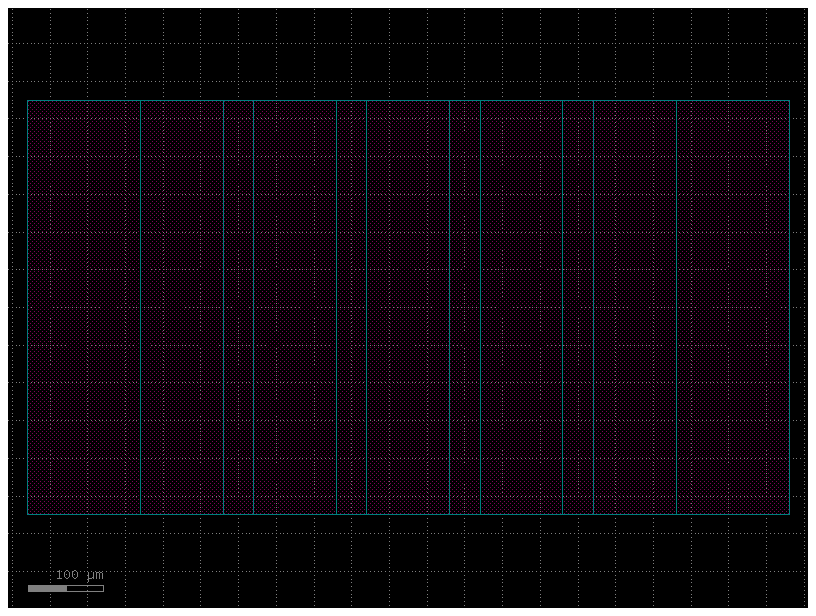

In [31]:
import gdsfactory as gf

# Define or import the 'pad' component
pad_component = gf.components.pad(size=(260, 550))  # Adjust parameters as necessary

# Create an array of 6 cells in one row with spacing
pad_array = gf.components.array(
    component=pad_component,
    spacing=(150, 0),  # Adjust the spacing if needed
    columns=6,
    rows=1,
    add_ports=True,
    centered=False
)

# Create a new component to contain the array
pad_cell = gf.Component()

# Add the array to the new component
pad_ref = pad_cell.add_ref(pad_array)

# Optionally adjust position of the pad_array within the pad_cell if needed
# For example, centering it within the pad_cell
pad_ref.move((0, 0))  # Adjust the move command as necessary

# Plot the component to visualize
pad_cell.plot()


In [28]:
from __future__ import annotations

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.typings import LayerSpec
import time  # for timestamp-based unique naming
from functools import partial


@gf.cell
def nanowire_cell(
    nw_length=0.1,
    nw_thick=0.0001,
    bridge_thickness=1,
    bridge_length=3
):
    cell = gf.Component('NANOWIRE_CELL')

    nw_s_l = 0.5
    nw_count = int(nw_length / nw_s_l)
    nw_residual = nw_length % nw_s_l

    center_nws = (0, 0)
    
    for i in range(nw_count):
        wire_thickness = nw_thick
        wire_corners_left = [
            (center_nws[0] + nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] - bridge_thickness / 2 - 0.3, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] - bridge_thickness / 2 - 0.3, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1)),
            (center_nws[0] + nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1))
        ]
        cell.add_polygon(wire_corners_left, layer=(5, 0))

        wire_corners_right = [
            (center_nws[0] - nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick * i),
            (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1)),
            (center_nws[0] - nw_s_l / 2, center_nws[1] - nw_thick / 2 + nw_thick * (i + 1))
        ]
        cell.add_polygon(wire_corners_right, layer=(5, 0))

        if nw_residual > 0.01:
            residual_corners = [
                (center_nws[0] + nw_s_l / 2 - nw_residual, center_nws[1] - nw_thick / 2),
                (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2),
                (center_nws[0] + bridge_thickness / 2 + 0.3, center_nws[1] - nw_thick / 2 + nw_thick),
                (center_nws[0] + nw_s_l / 2 - nw_residual, center_nws[1] - nw_thick / 2 + nw_thick)
            ]
            cell.add_polygon(residual_corners, layer=(5, 0))

    return cell


@gf.cell
def generate_device_cell(
    bridge_thickness=1,
    bridge_length=3,
    pad_dim_x=250,
    pad_dim_y=250,
    gap=40,
    nw_length=2.1,
    nw_thick=0.1,
    bridge_x_offset=0,
    bridge_y_offset=0,
    nanowire_x_offset=0,
    nanowire_y_offset=0
):
    unique_id = int(time.time())
    cell = gf.Component(f'NANOWIRE_BRIDGE_{unique_id}_nwl={nw_length:.2f}_nwt={nw_thick:.2f}')

    wg1 = cell.add_ref(gf.components.rectangle(size=(pad_dim_x, pad_dim_y), layer=(1, 0)))
    wg2 = cell.add_ref(gf.components.rectangle(size=(pad_dim_x, pad_dim_y), layer=(1, 0)))
    wg2.move((0, pad_dim_y + gap))

    center_bridge = (pad_dim_x - 15 + bridge_x_offset, (pad_dim_y + gap) / 2 + bridge_y_offset)
    dim_bridge = [bridge_thickness, bridge_length]
    corners_bridge = [
        (center_bridge[0] - dim_bridge[0] / 2, center_bridge[1] - dim_bridge[1] / 2),
        (center_bridge[0] - dim_bridge[0] / 2, center_bridge[1] + dim_bridge[1] / 2),
        (center_bridge[0] + dim_bridge[0] / 2, center_bridge[1] + dim_bridge[1] / 2),
        (center_bridge[0] + dim_bridge[0] / 2, center_bridge[1] - dim_bridge[1] / 2)
    ]

    microbridge = gf.Component()
    corners_up_trape = [
        (pad_dim_x - 20, pad_dim_y / 2 - 5),
        corners_bridge[0],
        corners_bridge[3],
        (pad_dim_x - 10, pad_dim_y / 2 - 5)
    ]

    corners_lo_trape = [
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 5),
        corners_bridge[1],
        corners_bridge[2],
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 5)
    ]

    corners_rec_up = [
        (pad_dim_x - 20, pad_dim_y / 2 - 5),
        (pad_dim_x - 20, pad_dim_y / 2 - 35),
        (pad_dim_x - 10, pad_dim_y / 2 - 35),
        (pad_dim_x - 10, pad_dim_y / 2 - 5)
    ]

    corners_rec_lo = [
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 5),
        (pad_dim_x - 20, pad_dim_y / 2 + gap + 35),
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 35),
        (pad_dim_x - 10, pad_dim_y / 2 + gap + 5)
    ]

    microbridge.add_polygon(corners_up_trape, layer=(1, 0))
    microbridge.add_polygon(corners_lo_trape, layer=(1, 0))
    microbridge.add_polygon(corners_rec_up, layer=(1, 0))
    microbridge.add_polygon(corners_rec_lo, layer=(1, 0))
    microbridge.add_polygon(corners_bridge, layer=(1, 0))

    combined_component = gf.Component()
    main_cell_ref = combined_component.add_ref(cell)
    microbridge_ref = combined_component.add_ref(microbridge)

    microbridge_ref.move((pad_dim_x - 6.25 * gap, 125))

    nw_component = nanowire_cell(nw_length=nw_length, nw_thick=nw_thick, bridge_thickness=bridge_thickness, bridge_length=bridge_length)
    nw_ref = combined_component.add_ref(nw_component)
    nw_ref.move((center_bridge[0] + nanowire_x_offset, center_bridge[1] + nanowire_y_offset))

    return combined_component


# Generate the device cell
combined_cell = generate_device_cell(
    bridge_x_offset=0,
    bridge_y_offset=0,
    nanowire_x_offset=0,
    nanowire_y_offset=124.5
)


# Define the pad cell array
def pad_cell_layer():
    return gf.components.rectangle(size=(260, 550), layer=(41, 0))

pad_cell = gf.Component()
pad_array = gf.components.array(
    component=pad_cell_layer,
    spacing=(150, 150),
    columns=6,
    rows=1,
    add_ports=True,
    centered=False
)
pad_ref = pad_cell.add_ref(pad_array)

# Create final component
t_shape_component = T_shape_with_four_bars(
    stem_width=160,
    stem_length=5700.0,
    stem_x_offset=0.0,
    stem_y_offset=0.0,
    bar1_width=5400.0,
    bar1_length=170,
    bar1_offset=820.0,
    bar2_width=5400.0,
    bar2_length=170,
    bar2_offset=2230.0,
    bar3_width=5400.0,
    bar3_length=170,
    bar3_offset=3640.0,
    bar4_width=5400.0,
    bar4_length=170,
    bar4_offset=5050.0
)

c2 = gf.Component()
t_shape_ref = c2.add_ref(t_shape_component)

# Move the pad array relative to the T-shape component
#pad_ref.move((0, t_shape_ref.bounding_box()[1].y + 150))  # Move pad_cell above t_shape_component by 150 units

c2.show()


2024-08-29 02:06:50.615 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `rectangle_S250_250_L1_0_074ab488_125000_125000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S250_250_L1_0_074ab488_125000_125000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 02:06:50.616 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `Unnamed_185_235000_145000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_185_235000_145000.dmove` instead. For further information, please consult the migration guide: https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-08-29 02:06:50.619 | WARNING  | gdsfactory.component:__getattribute__:137 - Getting `nanowire_cell_NL2p1_NT0_fb109800_0_150.move` in um is deprecated and will change to DataBaseUnits in

/tmp/ipykernel_19050/4184213130.py:74: UserWarning: Getting `rectangle_S250_250_L1_0_074ab488_125000_125000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `rectangle_S250_250_L1_0_074ab488_125000_125000.dmove` instead.
  wg2.move((0, pad_dim_y + gap))
/tmp/ipykernel_19050/4184213130.py:124: UserWarning: Getting `Unnamed_185_235000_145000.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_185_235000_145000.dmove` instead.
  microbridge_ref.move((pad_dim_x - 6.25 * gap, 125))
/tmp/ipykernel_19050/4184213130.py:128: UserWarning: Getting `nanowire_cell_NL2p1_NT0_fb109800_0_150.move` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `nanowire_cell_NL2p1_NT0_fb109800_0_150.dmove` instead.
  nw_ref.move((center_bridge[0] + nanowire_x_offset, center_bridge[1] + nanowire_y_offset))


2024-08-29 02:06:50.710 | WARNING  | kfactory.kcell:show:7940 - KLayout GUI version is older than the python klayout.GUI:0.28.16 Python:0.29.6. This might cause missing,unfunctional, or erroneous features. Please update your GUI to a version equal or higher than the python version for optimal performance.
